[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/accdavlo/calcolo-scientifico/blob/main/codes/poisson_FEM.ipynb)

# Finite element for Poisson

In this notebook we will solve the 1D Poisson equation given by the equations
$$-\partial_{xx} u = f .$$

Let us start with an example on the domain $\Omega=[0,1]$ with $f=4\pi^2 \sin(2\pi x)$ and homogeneous Dirichlet BC $u(0)=u(1)=0$.

In [7]:
import numpy as np
from scipy.interpolate import lagrange

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Geometry

In [8]:
class Geometry1D:
    def __init__(self, x_left, x_right, N=None):
        self.x_left = x_left
        self.x_right = x_right
        if N is not None:
            self.set_N(N)
    def set_linspace(self, xx):
        self.xx = xx
        self.x_left = self.xx[0]
        self.x_right = self.xx[-1]
        self.N = len(self.xx)
    
    def set_N(self,N):
        self.N = N
        self.xx = np.linspace(self.x_left,self.x_right, N)
        self.dx = self.xx[1]-self.xx[0]

We solve the equations with the **finite element method**.
1. Define the basis functions and their derivatives
2. Define the matrices in a reference element
3. Create the matrices on the whole domain by summing up all the terms
4. Solve the system

In [9]:
# Lagrangian basis functions (and its derivative)

def lagrange_poly(nodes,k):
    interpVal=np.zeros(np.size(nodes))
    interpVal[k] = 1.
    pp=lagrange(nodes,interpVal)
    return pp

def lagrange_basis(nodes,x,k):
    pp=lagrange_poly(nodes,k)
    return pp(x)

def lagrange_deriv(nodes,x,k):
    pp=lagrange_poly(nodes,k)
    dd=pp.deriv()
    return dd(x)

# FEM1D on reference elements
1. Try to interpolate the function $\sin(5x)$ on $[0,1]$ with 5, 10, 20 equispaced nodes
2. Plot the exact solution and the interpolated on a linspace in $[0,1]$

## Reference element

Note how in an interpolation formula
$$\int f(x)dx=\sum_{i=1}^{N_Q}f_i(x)w_i$$

In [10]:
class FEM1D_reference_element:
    def __init__(self, degree, x_nodes =None):
        self.x_left = 0
        self.x_right = 1
        self.degree = degree
        self.n_basis = self.degree+1
        if x_nodes is None:
            self.x_nodes = np.linspace(self.x_left, self.x_right, self.n_basis)
        else:
            self.x_nodes = x_nodes
        if len(self.x_nodes)!=self.n_basis:
            raise ValueError("The length of the input nodes %d should be degree +1= %d"%(len(self.x_nodes,self.n_basis))) 

        # quadrature nodes and weights (are defined on the interval (-1,1))
        # These are Legendre quadrature with n_points and are exact for 2*n_points+1 polynomials
        self.quad_nodes, self.quad_weights = np.polynomial.legendre.leggauss(self.degree+1)
        
        # Rescaling them on (0,1)
        self.quad_nodes = (self.quad_nodes+1)/2.*(self.x_right-self.x_left)+self.x_left
        self.quad_weights = self.quad_weights/2.*(self.x_right-self.x_left)


    def eval_basis(self, xx):
        # Evaluate all basis functions in xx
        yy = np.zeros((self.n_basis,len(xx)))
        for j in range(self.n_basis):
            yy[j,:]=lagrange_basis(self.x_nodes, xx, j)
        return yy

    def eval_der_basis(self, xx):
        # Evaluate the derivative of all the basis functions in xx
        yy = np.zeros((self.n_basis,len(xx)))
        for j in range(self.n_basis):
            yy[j,:]=lagrange_deriv(self.x_nodes, xx, j)
        return yy

    def eval_basis_and_deriv_in_quad(self):
        # Evaluate the basis functions and their derivatives in the quadrature nodes
        self.basis_in_quad = self.eval_basis(self.quad_nodes)
        self.deriv_in_quad = self.eval_der_basis(self.quad_nodes)
        
    def assemble_stiffness(self):
        # Assemble the stiffness matrix int phi_i' phi_j'
        if not hasattr(self,"deriv_in_quad"):
            self.eval_basis_and_deriv_in_quad()
        self.stiffness = np.zeros((self.n_basis,self.n_basis))
        for i in range(self.n_basis):
            for j in range(self.n_basis):
                self.stiffness[i,j] = np.dot(self.quad_weights, self.deriv_in_quad[i] * self.deriv_in_quad[j])
        return self.stiffness

    def assemble_mass(self):
        # Assemble the mass matrix int phi_i phi_j
        if not hasattr(self,"basis_in_quad"):
            self.eval_basis_and_deriv_in_quad()
        self.mass = np.zeros((self.n_basis,self.n_basis))
        for i in range(self.n_basis):
            for j in range(self.n_basis):
                self.mass[i,j] = np.dot(self.quad_weights, self.basis_in_quad[i,] * self.basis_in_quad[j,])
        return self.mass

### Testing the reference element

[[ 0.13333333  0.06666667 -0.03333333]
 [ 0.06666667  0.53333333  0.06666667]
 [-0.03333333  0.06666667  0.13333333]]
[[ 2.33333333 -2.66666667  0.33333333]
 [-2.66666667  5.33333333 -2.66666667]
 [ 0.33333333 -2.66666667  2.33333333]]


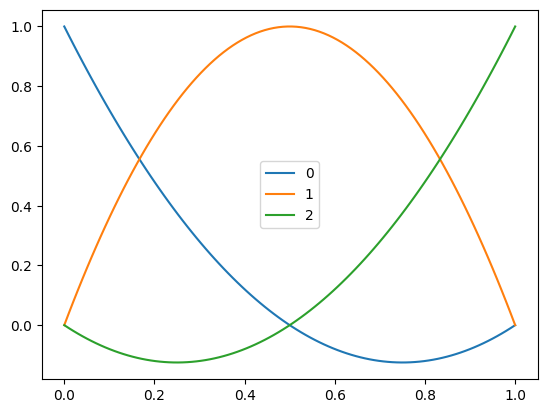

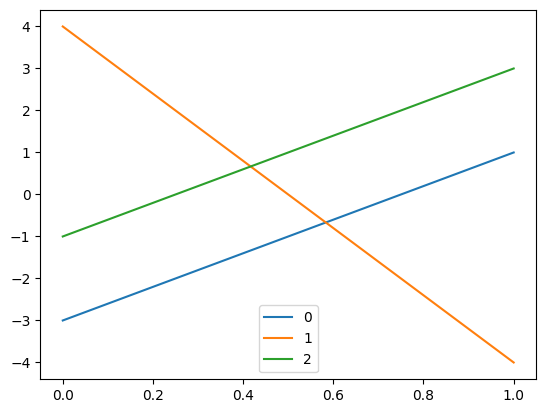

In [11]:
degree=2
fem1d = FEM1D_reference_element(degree)

xx = np.linspace(0,1,100)


plt.figure()
plt.plot(xx,fem1d.eval_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()
#plt.savefig("basis_reference_degree_%d.pdf"%(fem1d.degree))
#plt.savefig("basis_reference_degree_%d.png"%(fem1d.degree))
plt.figure()

plt.plot(xx,fem1d.eval_der_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()
print(fem1d.assemble_mass())


print(fem1d.assemble_stiffness())

# FEM structure on the whole mesh

[[0.05555556 0.02777778 0.         0.         0.         0.
  0.        ]
 [0.02777778 0.11111111 0.02777778 0.         0.         0.
  0.        ]
 [0.         0.02777778 0.11111111 0.02777778 0.         0.
  0.        ]
 [0.         0.         0.02777778 0.11111111 0.02777778 0.
  0.        ]
 [0.         0.         0.         0.02777778 0.11111111 0.02777778
  0.        ]
 [0.         0.         0.         0.         0.02777778 0.11111111
  0.02777778]
 [0.         0.         0.         0.         0.         0.02777778
  0.05555556]]
[[ 6. -6.  0.  0.  0.  0.  0.]
 [-6. 12. -6.  0.  0.  0.  0.]
 [ 0. -6. 12. -6.  0.  0.  0.]
 [ 0.  0. -6. 12. -6.  0.  0.]
 [ 0.  0.  0. -6. 12. -6.  0.]
 [ 0.  0.  0.  0. -6. 12. -6.]
 [ 0.  0.  0.  0.  0. -6.  6.]]


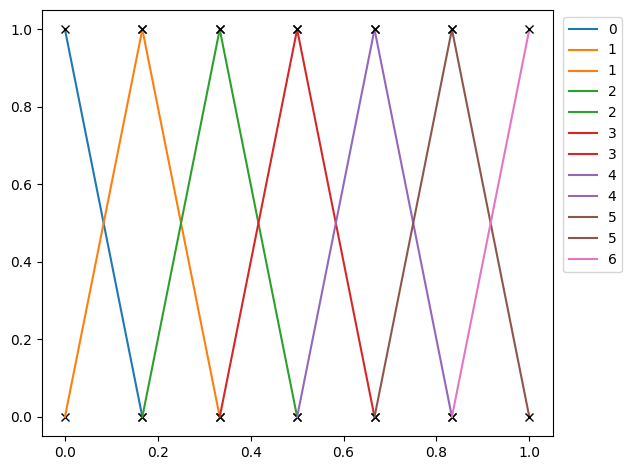

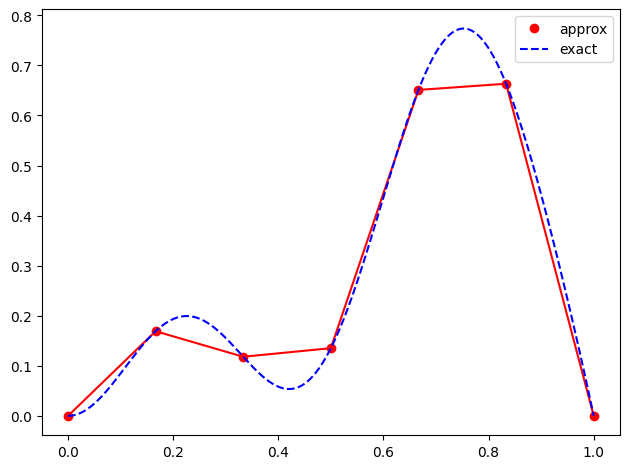

In [12]:
class FEM1D:
    def __init__(self,geom, reference_element):
        self.geom = geom
        self.reference_element = reference_element
        self.degree = self.reference_element.degree
        self.N_elem = self.geom.N-1
        self.set_degrees_of_freedom()

    def set_degrees_of_freedom(self):
        # Define the points on the whole domain for all subpoints in each cell
        self.N_dofs      = self.degree * self.N_elem + 1  # Number of total Degrees of Freedom = number of basis functions 
        self.DoFs        = np.zeros(self.N_dofs) # location of the Dofs
        self.DoFs_matrix = np.zeros((self.N_elem, self.degree+1)) # Location of the dofs but in a matrix
        self.dxs         = np.zeros(self.N_elem)    # Lengths of the cells
        self.elem2dofs   = np.zeros((self.N_elem, self.degree+1), dtype=np.int64) # maps a cell index and local dof index to global dof index
        
        for i in range(self.N_elem):
            dx = self.geom.xx[i+1]-self.geom.xx[i]
            self.dxs[i] = dx
            self.DoFs_matrix[i,:] = self.geom.xx[i]+self.reference_element.x_nodes*dx
            self.DoFs[i*self.degree:(i+1)*self.degree+1] = self.DoFs_matrix[i,:]
            self.elem2dofs[i,:] = np.arange(i*self.degree,(i+1)*self.degree+1)

    def assemble_stiffness_matrix(self):
        # assemble the matrix given by a_{ij} = \int phi_i' phi_j' = 1/h_i \int \hat{phi}_i' \hat{phi}_j'
        self.reference_element.assemble_stiffness()
        self.stiffness = np.zeros((self.N_dofs,self.N_dofs))
        for i in range(self.N_elem):
            h_i = self.dxs[i]
            for idof in range(self.degree+1):
                for jdof in range(self.degree+1):
                    self.stiffness[self.elem2dofs[i,idof],self.elem2dofs[i,jdof]]+= 1./h_i * self.reference_element.stiffness[idof, jdof] #use the reference element structure!!
            
        return self.stiffness
    
    def assemble_mass_matrix(self):
        # assemble the matrix given by a_{ij} = \int phi_i phi_j
        self.reference_element.assemble_mass()
        self.mass = np.zeros((self.N_dofs,self.N_dofs))
        for i in range(self.N_elem):
            h_i = self.dxs[i]
            for idof in range(self.degree+1):
                for jdof in range(self.degree+1):
                    self.mass[self.elem2dofs[i,idof],self.elem2dofs[i,jdof]]+= h_i*self.reference_element.mass[idof, jdof]
            
        return self.mass
        

    
    def plot_basis_functions(self):
        colors = list(mcolors.TABLEAU_COLORS.values())
        n_col = len(colors)
        x_plot = np.linspace(self.reference_element.x_left, self.reference_element.x_right,100)
        yy = self.reference_element.eval_basis(x_plot)
        plt.figure()
        for i in range(self.N_elem):
            x_plot_phys = x_plot*self.dxs[i]+self.geom.xx[i]
            for j in range(self.degree+1):
                dof_index = self.elem2dofs[i,j]
                plt.plot(x_plot_phys,yy[j,:],color=colors[dof_index%n_col],
                         label = dof_index)
                plt.plot(self.DoFs_matrix[i,j],1., "xk")
                plt.plot(self.DoFs_matrix[i,j],0., "xk")
        plt.legend(bbox_to_anchor=(1.15, 1.0))
        plt.tight_layout()
        #plt.savefig("basis_functions_N_%d_degree_%d.pdf"%(self.N_elem,self.degree))
        #plt.savefig("basis_functions_N_%d_degree_%d.png"%(self.N_elem,self.degree))
    
    def plot_function(self, u_coeff, u_ex_lambda = None):
        x_plot = np.linspace(self.reference_element.x_left, self.reference_element.x_right,100)
        basis_plot = self.reference_element.eval_basis(x_plot)
        plt.figure()
        for i in range(self.N_elem):
            x_plot_phys = x_plot*self.dxs[i]+self.geom.xx[i]
            yy = np.zeros_like(x_plot)
            for j in range(self.degree+1):
                dof_index = self.elem2dofs[i,j]
                yy += u_coeff[dof_index]*basis_plot[j,:]
            plt.plot(x_plot_phys,yy,"-r")
        plt.plot(self.DoFs,u_coeff, "ro", label="approx")

        if u_ex_lambda is not None:
            x_plot = np.linspace(self.geom.x_left, self.geom.x_right, 1000)
            y_plot = u_ex_lambda(x_plot)
            plt.plot(x_plot,  y_plot, "b--", label="exact")
        plt.legend()
        plt.tight_layout()    
    
# Basis functions
reference_element = FEM1D_reference_element(1)
geom = Geometry1D(0,1,N=7)
fem1d = FEM1D(geom,reference_element)

fem1d.plot_basis_functions()

u_lambda = lambda x : (1-x)*x *(5*x**2+0.5*x+np.sin(10*x))
u_coeff = u_lambda(fem1d.DoFs)
fem1d.plot_function(u_coeff, u_lambda)
print(fem1d.assemble_mass_matrix())
print(fem1d.assemble_stiffness_matrix()) 

In [13]:
class Poisson_Finite_Element_1D:
    def __init__(self,geometry, boundary, f_lambda, degree=1, sigma_lambda=None):
        self.geometry = geometry
        self.boundary = boundary
        self.f_lambda = f_lambda
        self.degree = degree
        if sigma_lambda:
            self.sigma_lambda = sigma_lambda
        self.define_fem()

    def define_fem(self):
        reference_element = FEM1D_reference_element(self.degree)
        self.fem1d = FEM1D(self.geometry, reference_element)

    def set_exact_solution(self, uex_lambda):
        self.uex_lambda = uex_lambda

    def assemble_matrix(self):
        self.A = self.fem1d.assemble_stiffness_matrix()
        
        self.f = self.fem1d.assemble_mass_matrix()@self.f_lambda(self.fem1d.DoFs)
        self.apply_BC()

    def apply_BC(self,boundary = None):
        if boundary is not None:
            self.boundary = boundary
        if not hasattr(self,"boundary"):
            raise ValueError("Boundaries are not set yet")
        
        if self.boundary["left"][0]=="dirichlet":
            # Dirichlet in x_left
            self.A[0, :] = 0.
            self.A[0, 0] = 1.
            self.f[0] = self.boundary["left"][1]
        elif self.boundary["left"][0]=="neumann":
            # Neumann in x_left
            self.f[0] -= self.boundary["left"][1]
        else:
            raise ValueError("Boundary %s not implemented"%(self.boundary["left"][0]))
            
        if self.boundary["right"][0]=="dirichlet":
            # Dirichlet in x_right
            self.A[-1, :] = 0.
            self.A[-1, -1] = 1.
            self.f[-1] = self.boundary["right"][1]
        elif self.boundary["right"][0]=="neumann":
            # Neumann in x_right
            self.f[-1] += self.boundary["right"][1]

    def solve(self, N=None):
        if N is not None:
            self.geometry.set_N(N)
            self.define_fem()
            self.assemble_matrix()
        if not hasattr(self,"A") or not hasattr(self,"f"):
            self.assemble_matrix()
        self.uu = np.linalg.solve(self.A, self.f)
        if hasattr(self,"uex_lambda"):
            uex = self.uex_lambda(self.fem1d.DoFs)
            self.error = np.linalg.norm(self.uu-uex)/np.linalg.norm(uex)
        else:
            self.error = np.nan
        return self.geometry, self.uu, self.error

2.2962713503354433e-05


<Figure size 640x480 with 0 Axes>

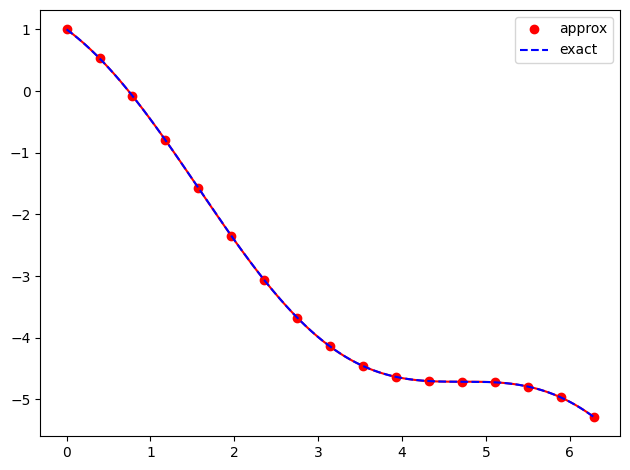

In [14]:
geom = Geometry1D(0.,2*np.pi,N=5)

boundary = dict()
boundary["left"] = ["dirichlet", 1.]
#boundary["right"] = ["dirichlet", 1.-2*np.pi]
boundary["right"] = ["neumann", -1.]

uex_lambda = lambda x: np.cos(x)-x
f_lambda = lambda x: np.cos(x)

problem = Poisson_Finite_Element_1D(geom, boundary, f_lambda, degree=4)
problem.set_exact_solution(uex_lambda)

plt.figure()
geom,uu,error = problem.solve()

problem.fem1d.plot_function(uu,uex_lambda)
#plt.plot(problem.fem1d.DoFs,uu,label="approximation")
#plt.plot(problem.fem1d.DoFs,uex_lambda(problem.fem1d.DoFs),label="exact")
#plt.legend()
print(error)

In [15]:
class ConvergenceAnalysis:
    def __init__(self, problem, Ns=None):
        self.problem = problem
        if Ns is None:
            self.Ns = np.int64(2**np.linspace(3,10,8))
        else:
            self.Ns = Ns
        self.Ns = np.array(self.Ns)
    
    def analyse(self):
        self.errors = np.zeros(len(self.Ns))
        self.orders = np.zeros(len(self.Ns)-1)
        
        for iN, N in enumerate(self.Ns):
            _,_,self.errors[iN] =self.problem.solve(N)
            if iN>0:
                self.orders[iN-1] = np.log(self.errors[iN]/self.errors[iN-1])/np.log(self.Ns[iN-1]/self.Ns[iN])
            
    def plot_error_convergence(self):
        if not hasattr(self,"errors"):
            self.analyse()
        fig, ax = plt.subplots(1,1)
        ax.loglog(self.Ns, self.errors, label ="errors")
        average_order = np.mean(self.orders)
        order_plus = np.ceil(average_order)
        order_minus = np.floor(average_order)
        ax.loglog(self.Ns, (self.Ns/self.Ns[0])**(-order_plus)*self.errors[0],"--", label =f"order {order_plus}")
        ax.loglog(self.Ns, (self.Ns/self.Ns[0])**(-order_minus)*self.errors[0],"--", label =f"order {order_minus}")
        ax.set_xlabel("Number of points in mesh")
        ax.set_ylabel("Relative error")
        plt.legend()
        
        

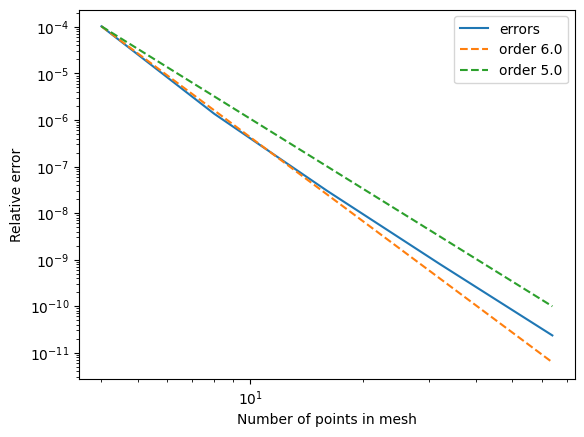

In [16]:
Ns = np.int64(2**np.linspace(2,6,5))
convergence = ConvergenceAnalysis(problem, Ns = Ns)
convergence.plot_error_convergence()

# Exercises
1. Irregular domain
2. Different problem (e.g. with reaction term)
3. Non-constant coefficient of the Laplacian term
4. Sparse implementation of the matrix

## 1. Irregular domain variation

In [17]:
rng = np.random.RandomState(0)

Since, after adding Gaussian noise, points could end up being outside of $[0, 1]$, they need to be rescaled.

In [18]:
def minmax_scaler(arr, *, vmin=0, vmax=1):
    arr_min, arr_max = arr.min(), arr.max()
    return ((arr - arr_min) / (arr_max - arr_min)) * (vmax - vmin) + vmin

In [19]:
class Geometry1DIrregular:
    def __init__(self, x_left, x_right, std=0.1, N=None):
        self.x_left = x_left
        self.x_right = x_right
        self.std = std
        if N is not None:
            self.set_N(N)
    def set_linspace(self, xx):
        self.xx = xx
        self.x_left = self.xx[0]
        self.x_right = self.xx[-1]
        self.N = len(self.xx)
    
    def set_N(self,N):
        self.N = N
        self.xx = np.linspace(self.x_left,self.x_right, N)
        self.xx = rng.normal(self.xx, self.std, np.size(self.xx))    #adding some Gaussian noise to points
        self.xx.sort()
        self.xx = minmax_scaler(self.xx, vmin=self.x_left, vmax=self.x_right)
        self.dx = self.xx[1]-self.xx[0]

### Testing the reference element

Deterministic points:
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878

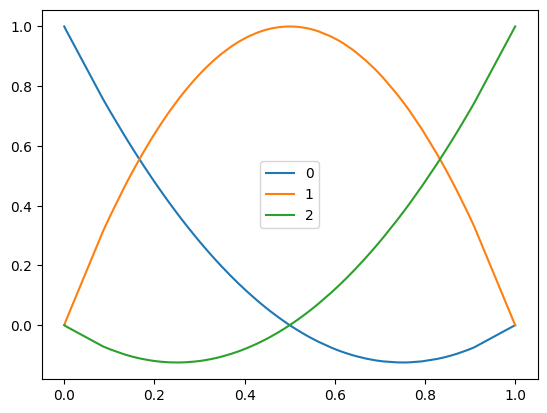

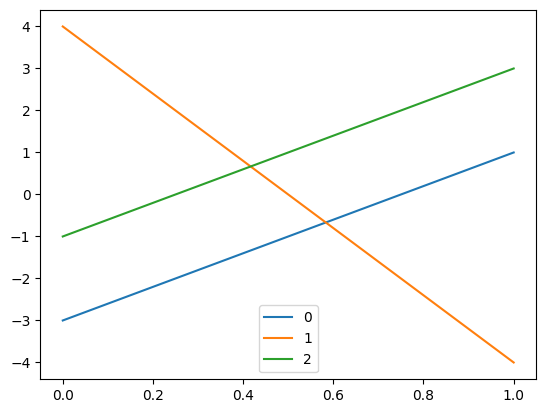

In [20]:
degree=2
fem1d = FEM1D_reference_element(degree)

xx = np.linspace(0, 1, 100)
print("Deterministic points:")
print(xx)
xx = rng.normal(xx, 0.1, np.size(xx))    #adding some Gaussian noise to points
xx.sort()
xx = minmax_scaler(xx)
print("Noisy points:")
print(xx)


plt.figure()
plt.plot(xx,fem1d.eval_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()
#plt.savefig("basis_reference_degree_%d.pdf"%(fem1d.degree))
#plt.savefig("basis_reference_degree_%d.png"%(fem1d.degree))
plt.figure()

plt.plot(xx,fem1d.eval_der_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()
print(fem1d.assemble_mass())


print(fem1d.assemble_stiffness())

### Testing basis functions

[[0.05236111 0.02618055 0.         0.         0.         0.
  0.        ]
 [0.02618055 0.05837626 0.00300758 0.         0.         0.
  0.        ]
 [0.         0.00300758 0.12085344 0.05741914 0.         0.
  0.        ]
 [0.         0.         0.05741914 0.13076689 0.0079643  0.
  0.        ]
 [0.         0.         0.         0.0079643  0.13700269 0.06053704
  0.        ]
 [0.         0.         0.         0.         0.06053704 0.14419018
  0.01155805]
 [0.         0.         0.         0.         0.         0.01155805
  0.0231161 ]]
[[  6.3660482   -6.3660482    0.           0.           0.
    0.           0.        ]
 [ -6.3660482   61.78161757 -55.41556937   0.           0.
    0.           0.        ]
 [  0.         -55.41556937  58.31820197  -2.90263259   0.
    0.           0.        ]
 [  0.           0.          -2.90263259  23.82934224 -20.92670965
    0.           0.        ]
 [  0.           0.           0.         -20.92670965  23.67984488
   -2.75313522   0.        ]
 

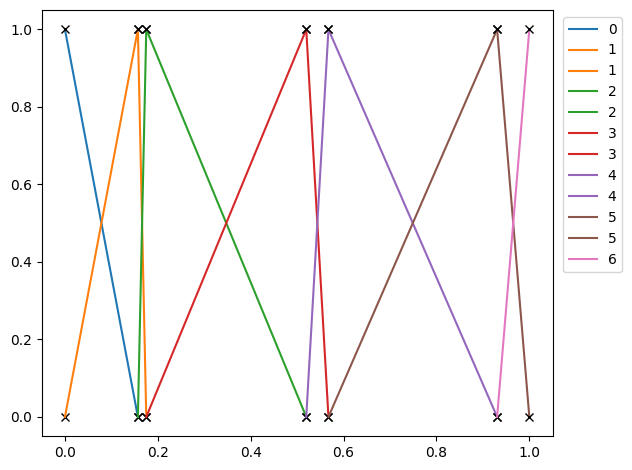

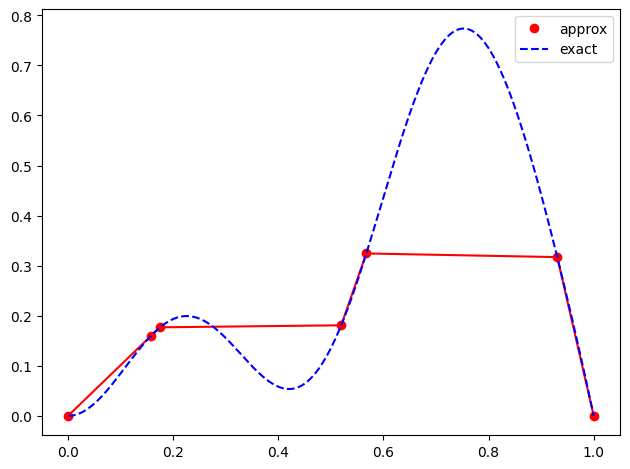

In [21]:
# Basis functions
reference_element = FEM1D_reference_element(1)
geom = Geometry1DIrregular(0,1,N=7)
fem1d = FEM1D(geom,reference_element)

fem1d.plot_basis_functions()

u_lambda = lambda x : (1-x)*x *(5*x**2+0.5*x+np.sin(10*x))
u_coeff = u_lambda(fem1d.DoFs)
fem1d.plot_function(u_coeff, u_lambda)
print(fem1d.assemble_mass_matrix())
print(fem1d.assemble_stiffness_matrix())

3.72937114953786e-05


<Figure size 640x480 with 0 Axes>

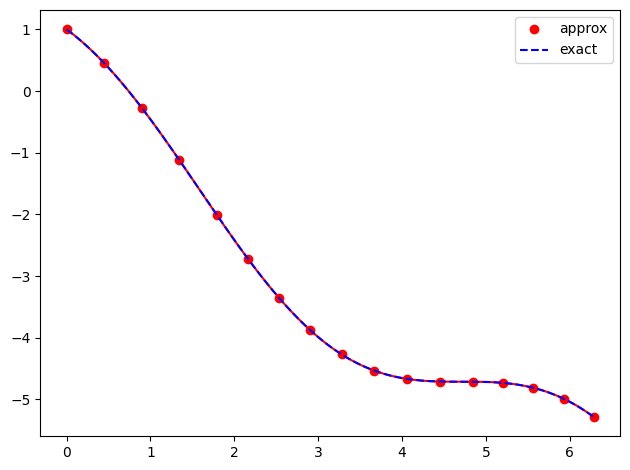

In [22]:
geom = Geometry1DIrregular(0.,2*np.pi, std = 0.1, N=5)

boundary = dict()
boundary["left"] = ["dirichlet", 1.]
#boundary["right"] = ["dirichlet", 1.-2*np.pi]
boundary["right"] = ["neumann", -1.]

uex_lambda = lambda x: np.cos(x)-x
f_lambda = lambda x: np.cos(x)

problem = Poisson_Finite_Element_1D(geom, boundary, f_lambda, degree=4)
problem.set_exact_solution(uex_lambda)

plt.figure()
geom,uu,error = problem.solve()

problem.fem1d.plot_function(uu,uex_lambda)
#plt.plot(problem.fem1d.DoFs,uu,label="approximation")
#plt.plot(problem.fem1d.DoFs,uex_lambda(problem.fem1d.DoFs),label="exact")
#plt.legend()
print(error)

## 2.a Reaction term (constant)

In [23]:
class Poisson_Finite_Element_1D_c_reaction:
    def __init__(self,geometry, boundary, f_lambda, sigma, degree=1):
        self.geometry = geometry
        self.boundary = boundary
        self.f_lambda = f_lambda
        self.degree = degree
        self.sigma = sigma
        self.define_fem()

    def define_fem(self):
        reference_element = FEM1D_reference_element(self.degree)
        self.fem1d = FEM1D(self.geometry, reference_element)

    def set_exact_solution(self, uex_lambda):
        self.uex_lambda = uex_lambda

    def assemble_matrix(self):
        self.A = self.fem1d.assemble_stiffness_matrix() + self.sigma * self.fem1d.assemble_mass_matrix()
                    
        self.f = self.fem1d.assemble_mass_matrix()@self.f_lambda(self.fem1d.DoFs)
        self.apply_BC()

    def apply_BC(self,boundary = None):
        if boundary is not None:
            self.boundary = boundary
        if not hasattr(self,"boundary"):
            raise ValueError("Boundaries are not set yet")
        
        if self.boundary["left"][0]=="dirichlet":
            # Dirichlet in x_left
            self.A[0, :] = 0.
            self.A[0, 0] = 1.
            self.f[0] = self.boundary["left"][1]
        elif self.boundary["left"][0]=="neumann":
            # Neumann in x_left
            self.f[0] -= self.boundary["left"][1]
        else:
            raise ValueError("Boundary %s not implemented"%(self.boundary["left"][0]))
            
        if self.boundary["right"][0]=="dirichlet":
            # Dirichlet in x_right
            self.A[-1, :] = 0.
            self.A[-1, -1] = 1.
            self.f[-1] = self.boundary["right"][1]
        elif self.boundary["right"][0]=="neumann":
            # Neumann in x_right
            self.f[-1] += self.boundary["right"][1]

    def solve(self, N=None):
        if N is not None:
            self.geometry.set_N(N)
            self.define_fem()
            self.assemble_matrix()
        if not hasattr(self,"A") or not hasattr(self,"f"):
            self.assemble_matrix()
        self.uu = np.linalg.solve(self.A, self.f)
        if hasattr(self,"uex_lambda"):
            uex = self.uex_lambda(self.fem1d.DoFs)
            self.error = np.linalg.norm(self.uu-uex)/np.linalg.norm(uex)
        else:
            self.error = np.nan
        return self.geometry, self.uu, self.error

1.7314566984301937e-05


<Figure size 640x480 with 0 Axes>

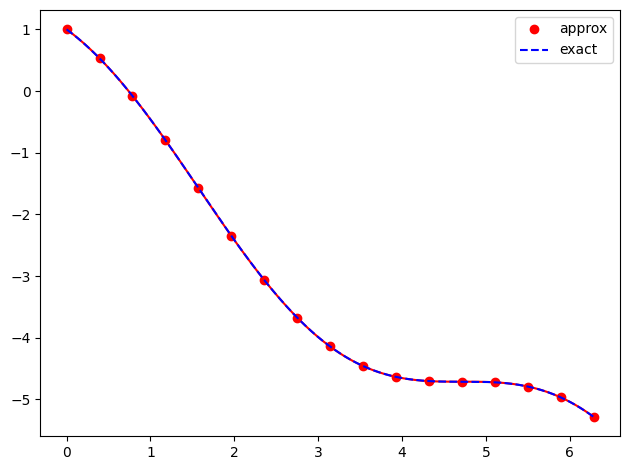

In [26]:
geom = Geometry1D(0.,2*np.pi, N=5)

boundary = dict()
boundary["left"] = ["dirichlet", 1.]
#boundary["right"] = ["dirichlet", 1.-2*np.pi]
boundary["right"] = ["neumann", -1.]

uex_lambda = lambda x: np.cos(x)-x
f_lambda = lambda x: np.cos(x) + 3 * (np.cos(x) - x)

problem = Poisson_Finite_Element_1D_c_reaction(geom, boundary, f_lambda, degree=4, sigma=3)
problem.set_exact_solution(uex_lambda)

plt.figure()
geom,uu,error = problem.solve()

problem.fem1d.plot_function(uu,uex_lambda)
#plt.plot(problem.fem1d.DoFs,uu,label="approximation")
#plt.plot(problem.fem1d.DoFs,uex_lambda(problem.fem1d.DoFs),label="exact")
#plt.legend()
print(error)

## 2.b Reaction term (function)

### Unitary reactioned term

In [30]:
class FEM1D_unitary_reaction:
    def __init__(self, degree, x_left, x_right, sigma_lambda, x_nodes =None):
        self.x_left = x_left
        self.x_right = x_right
        self.degree = degree
        self.n_basis = self.degree+1
        self.sigma_lambda = sigma_lambda
        if x_nodes is None:
            self.x_nodes = np.linspace(self.x_left, self.x_right, self.n_basis)
        else:
            self.x_nodes = x_nodes
        if len(self.x_nodes)!=self.n_basis:
            raise ValueError("The length of the input nodes %d should be degree +1= %d"%(len(self.x_nodes,self.n_basis))) 

        # quadrature nodes and weights (are defined on the interval (-1,1))
        # These are Legendre quadrature with n_points and are exact for 2*n_points+1 polynomials
        self.quad_nodes, self.quad_weights = np.polynomial.legendre.leggauss(self.degree+1)
        
        # Rescaling them on (x_left,x_right)
        self.quad_nodes = (self.quad_nodes+1)/2.*(self.x_right-self.x_left)+self.x_left
        self.quad_weights = self.quad_weights/2.*(self.x_right-self.x_left)


    def eval_basis(self, xx):
        # Evaluate all basis functions in xx
        yy = np.zeros((self.n_basis,len(xx)))
        for j in range(self.n_basis):
            yy[j,:]=lagrange_basis(self.x_nodes, xx, j)
        return yy

    def eval_basis_and_sigma_in_quad(self):
        # Evaluate the basis functions and their derivatives in the quadrature nodes
        self.basis_in_quad = self.eval_basis(self.quad_nodes)
        self.sigma_in_quad = self.sigma_lambda(self.quad_nodes)

    def assemble_mass(self):
        # Assemble the mass matrix int phi_i phi_j
        if not hasattr(self,"basis_in_quad"):
            self.eval_basis_and_sigma_in_quad()
        self.mass = np.zeros((self.n_basis,self.n_basis))
        for i in range(self.n_basis):
            for j in range(self.n_basis):
                self.mass[i,j] = np.dot(self.quad_weights, self.basis_in_quad[i] * self.basis_in_quad[j] * self.sigma_in_quad)
        return self.mass

### Testing the reference element

[[ 0.45  0.2  -0.15]
 [ 0.2   2.4   0.4 ]
 [-0.15  0.4   0.75]]


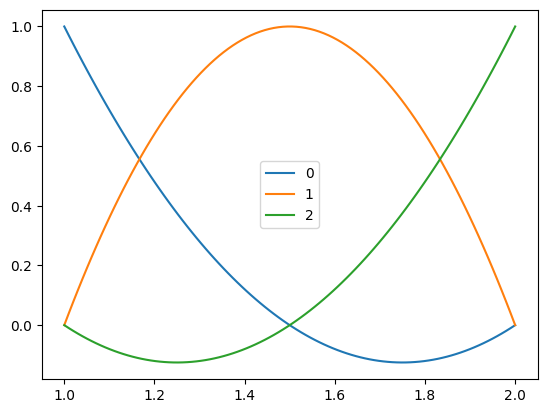

<Figure size 640x480 with 0 Axes>

In [31]:
degree=2
fem1d = FEM1D_unitary_reaction(degree, 1, 2, sigma_lambda= lambda x: 3*x)

xx = np.linspace(1,2,100)


plt.figure()
plt.plot(xx,fem1d.eval_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()
#plt.savefig("basis_reference_degree_%d.pdf"%(fem1d.degree))
#plt.savefig("basis_reference_degree_%d.png"%(fem1d.degree))
plt.figure()

#plt.plot(xx,fem1d.eval_der_basis(xx).T, label=np.arange(fem1d.n_basis))
#plt.legend()
print(fem1d.assemble_mass())


#print(fem1d.assemble_stiffness())

### FEM structure on the whole mesh

In [47]:
class FEM1D_reaction:
    def __init__(self,geom, sigma_lambda, degree, reference_element):
        self.geom = geom
        self.reference_element = reference_element
        self.degree = degree
        self.sigma_lambda = sigma_lambda
        self.x_nodes = np.linspace(self.geom.x_left, self.geom.x_right, self.degree+1)
        self.N_elem = self.geom.N-1
        self.set_degrees_of_freedom()

    def set_degrees_of_freedom(self):
        # Define the points on the whole domain for all subpoints in each cell
        self.N_dofs      = self.degree * self.N_elem + 1  # Number of total Degrees of Freedom = number of basis functions 
        self.DoFs        = np.zeros(self.N_dofs) # location of the Dofs
        self.DoFs_matrix = np.zeros((self.N_elem, self.degree+1)) # Location of the dofs but in a matrix
        self.dxs         = np.zeros(self.N_elem)    # Lengths of the cells
        self.elem2dofs   = np.zeros((self.N_elem, self.degree+1), dtype=np.int64) # maps a cell index and local dof index to global dof index
        
        for i in range(self.N_elem):
            dx = self.geom.xx[i+1]-self.geom.xx[i]
            self.dxs[i] = dx
            self.DoFs_matrix[i,:] = self.geom.xx[i]+self.x_nodes*dx
            self.DoFs[i*self.degree:(i+1)*self.degree+1] = self.DoFs_matrix[i,:]
            self.elem2dofs[i,:] = np.arange(i*self.degree,(i+1)*self.degree+1)
    
    def assemble_reactioned_mass_matrix(self):
        # assemble the matrix given by a_{ij} = \int phi_i phi_j
        self.mass = np.zeros((self.N_dofs,self.N_dofs))
        for i in range(self.N_elem):
            h_i = self.dxs[i]
            # Initializing the reference element in the specific interval,
            # specifying the value of the "mass" matrix in such element
            current_reference_element = self.reference_element(self.degree, self.geom.xx[i], self.geom.xx[i+1], self.sigma_lambda)
            for idof in range(self.degree+1):
                for jdof in range(self.degree+1):
                    self.mass[self.elem2dofs[i,idof],self.elem2dofs[i,jdof]]+= current_reference_element.assemble_mass()[idof, jdof]
            
        return self.mass  

### Poisson problem

In [48]:
class Poisson_Finite_Element_1D_reaction:
    def __init__(self,geometry, boundary, f_lambda, sigma_lambda, degree=1):
        self.geometry = geometry
        self.boundary = boundary
        self.f_lambda = f_lambda
        self.degree = degree
        self.sigma_lambda = sigma_lambda
        self.define_fem()

    def define_fem(self):
        reference_element = FEM1D_reference_element(self.degree)
        self.fem1d = FEM1D(self.geometry, reference_element)
        self.reaction_mass_matrix = FEM1D_reaction(self.geometry, self.sigma_lambda, self.degree, FEM1D_unitary_reaction).assemble_reactioned_mass_matrix()

    def set_exact_solution(self, uex_lambda):
        self.uex_lambda = uex_lambda

    def assemble_matrix(self):
        self.A = self.fem1d.assemble_stiffness_matrix() + self.reaction_mass_matrix
        
        self.f = self.fem1d.assemble_mass_matrix()@self.f_lambda(self.fem1d.DoFs)
        self.apply_BC()

    def apply_BC(self,boundary = None):
        if boundary is not None:
            self.boundary = boundary
        if not hasattr(self,"boundary"):
            raise ValueError("Boundaries are not set yet")
        
        if self.boundary["left"][0]=="dirichlet":
            # Dirichlet in x_left
            self.A[0, :] = 0.
            self.A[0, 0] = 1.
            self.f[0] = self.boundary["left"][1]
        elif self.boundary["left"][0]=="neumann":
            # Neumann in x_left
            self.f[0] -= self.boundary["left"][1]
        else:
            raise ValueError("Boundary %s not implemented"%(self.boundary["left"][0]))
            
        if self.boundary["right"][0]=="dirichlet":
            # Dirichlet in x_right
            self.A[-1, :] = 0.
            self.A[-1, -1] = 1.
            self.f[-1] = self.boundary["right"][1]
        elif self.boundary["right"][0]=="neumann":
            # Neumann in x_right
            self.f[-1] += self.boundary["right"][1]

    def solve(self, N=None):
        if N is not None:
            self.geometry.set_N(N)
            self.define_fem()
            self.assemble_matrix()
        if not hasattr(self,"A") or not hasattr(self,"f"):
            self.assemble_matrix()
        self.uu = np.linalg.solve(self.A, self.f)
        if hasattr(self,"uex_lambda"):
            uex = self.uex_lambda(self.fem1d.DoFs)
            self.error = np.linalg.norm(self.uu-uex)/np.linalg.norm(uex)
        else:
            self.error = np.nan
        return self.geometry, self.uu, self.error

2.4944055599120316e-05


<Figure size 640x480 with 0 Axes>

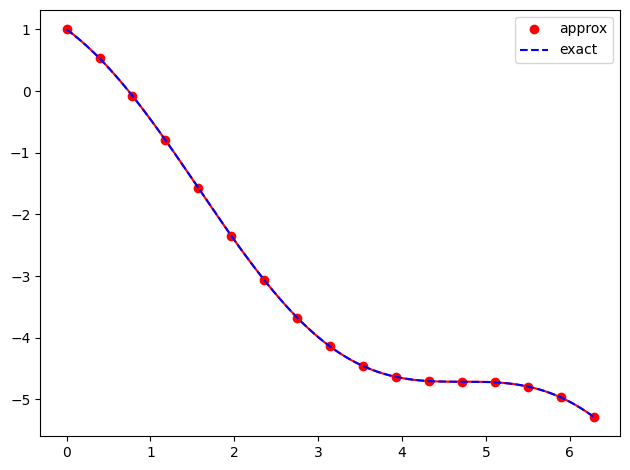

In [51]:
geom = Geometry1D(0.,2*np.pi,N=5)

boundary = dict()
boundary["left"] = ["dirichlet", 1.]
#boundary["right"] = ["dirichlet", 1.-2*np.pi]
boundary["right"] = ["neumann", -1.]

uex_lambda = lambda x: np.cos(x)-x
f_lambda = lambda x: np.cos(x) + 2 * x * (np.cos(x)-x)

problem = Poisson_Finite_Element_1D_reaction(geom, boundary, f_lambda, sigma_lambda=lambda x: 2*x, degree=4)
problem.set_exact_solution(uex_lambda)

plt.figure()
geom,uu,error = problem.solve()

problem.fem1d.plot_function(uu,uex_lambda)
#plt.plot(problem.fem1d.DoFs,uu,label="approximation")
#plt.plot(problem.fem1d.DoFs,uex_lambda(problem.fem1d.DoFs),label="exact")
#plt.legend()
print(error)

## 3. Non-constant coefficient of the Laplacian term

I will assume that, given the equation $$-div(\mu \nabla u) = f$$ the "Laplacian term" is the left-hand side; thus, we will deal with (given we are in $\mathbb{R}$) $$-(\mu 'u' + \mu u'')=f$$
I will solve a homogeneous Dirichlet problem.

Let's try with the same approach of the last exercise, but by applying $\mu$ on the stiffness matrix instead of the mass matrix.

### Unitary term

In [52]:
class FEM1D_unitary_non_c:
    def __init__(self, degree, x_left, x_right, mu_lambda, x_nodes =None):
        self.x_left = x_left
        self.x_right = x_right
        self.degree = degree
        self.n_basis = self.degree+1
        self.mu_lambda = mu_lambda
        if x_nodes is None:
            self.x_nodes = np.linspace(self.x_left, self.x_right, self.n_basis)
        else:
            self.x_nodes = x_nodes
        if len(self.x_nodes)!=self.n_basis:
            raise ValueError("The length of the input nodes %d should be degree +1= %d"%(len(self.x_nodes,self.n_basis))) 

        # quadrature nodes and weights (are defined on the interval (-1,1))
        # These are Legendre quadrature with n_points and are exact for 2*n_points+1 polynomials
        self.quad_nodes, self.quad_weights = np.polynomial.legendre.leggauss(self.degree+1)
        
        # Rescaling them on (x_left,x_right)
        self.quad_nodes = (self.quad_nodes+1)/2.*(self.x_right-self.x_left)+self.x_left
        self.quad_weights = self.quad_weights/2.*(self.x_right-self.x_left)

    def eval_basis_and_mu_in_quad(self):
        # Evaluate the derivative of the basis function and mu in the quadrature nodes
        self.deriv_in_quad = self.eval_der_basis(self.quad_nodes)
        self.mu_in_quad = self.mu_lambda(self.quad_nodes)
    
    def eval_der_basis(self, xx):
        # Evaluate the derivative of all the basis functions in xx
        yy = np.zeros((self.n_basis,len(xx)))
        for j in range(self.n_basis):
            yy[j,:]=lagrange_deriv(self.x_nodes, xx, j)
        return yy
        
    def assemble_stiffness(self):
        # Assemble the stiffness matrix int phi_i' phi_j'
        if not hasattr(self,"deriv_in_quad"):
            self.eval_basis_and_deriv_in_quad()
        self.stiffness = np.zeros((self.n_basis,self.n_basis))
        for i in range(self.n_basis):
            for j in range(self.n_basis):
                self.stiffness[i,j] = np.dot(self.quad_weights, self.deriv_in_quad[i] * self.deriv_in_quad[j] * self.mu_in_quad)
        return self.stiffness

### Testing the reference element

<Figure size 640x480 with 0 Axes>

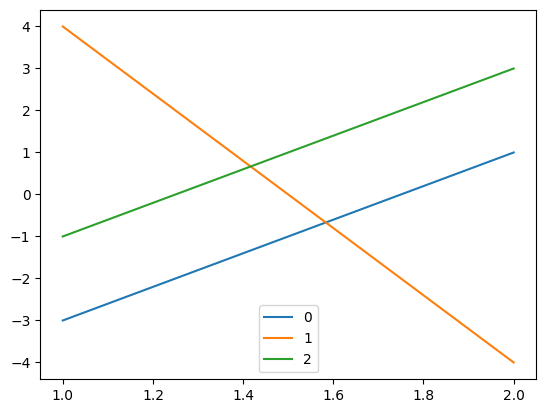

<Figure size 640x480 with 0 Axes>

In [55]:
degree=2
fem1d = FEM1D_unitary_non_c(degree, 1, 2, mu_lambda= lambda x: 3*x)

xx = np.linspace(1,2,100)


plt.figure()
plt.plot(xx,fem1d.eval_der_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()
#plt.savefig("basis_reference_degree_%d.pdf"%(fem1d.degree))
#plt.savefig("basis_reference_degree_%d.png"%(fem1d.degree))
plt.figure()

#plt.plot(xx,fem1d.eval_der_basis(xx).T, label=np.arange(fem1d.n_basis))
#plt.legend()


#print(fem1d.assemble_stiffness())

### FEM structure on the whole mesh

In [ ]:
class FEM1D_nonc:
    def __init__(self,geom, mu_lambda, degree, reference_element):
        self.geom = geom
        self.reference_element = reference_element
        self.degree = degree
        self.mu_lambda = mu_lambda
        self.x_nodes = np.linspace(self.geom.x_left, self.geom.x_right, self.degree+1)
        self.N_elem = self.geom.N-1
        self.set_degrees_of_freedom()

    def set_degrees_of_freedom(self):
        # Define the points on the whole domain for all subpoints in each cell
        self.N_dofs      = self.degree * self.N_elem + 1  # Number of total Degrees of Freedom = number of basis functions 
        self.DoFs        = np.zeros(self.N_dofs) # location of the Dofs
        self.DoFs_matrix = np.zeros((self.N_elem, self.degree+1)) # Location of the dofs but in a matrix
        self.dxs         = np.zeros(self.N_elem)    # Lengths of the cells
        self.elem2dofs   = np.zeros((self.N_elem, self.degree+1), dtype=np.int64) # maps a cell index and local dof index to global dof index
        
        for i in range(self.N_elem):
            dx = self.geom.xx[i+1]-self.geom.xx[i]
            self.dxs[i] = dx
            self.DoFs_matrix[i,:] = self.geom.xx[i]+self.x_nodes*dx
            self.DoFs[i*self.degree:(i+1)*self.degree+1] = self.DoFs_matrix[i,:]
            self.elem2dofs[i,:] = np.arange(i*self.degree,(i+1)*self.degree+1)
    
    def assemble_reactioned_mass_matrix(self):
        # assemble the matrix given by a_{ij} = \int phi_i phi_j
        self.mass = np.zeros((self.N_dofs,self.N_dofs))
        for i in range(self.N_elem):
            h_i = self.dxs[i]
            # Initializing the reference element in the specific interval,
            # specifying the value of the "mass" matrix in such element
            current_reference_element = self.reference_element(self.degree, self.geom.xx[i], self.geom.xx[i+1], self.sigma_lambda)
            for idof in range(self.degree+1):
                for jdof in range(self.degree+1):
                    self.mass[self.elem2dofs[i,idof],self.elem2dofs[i,jdof]]+= current_reference_element.assemble_mass()[idof, jdof]
            
        return self.mass

    def assemble_nonc_stiffness_matrix(self):
        # assemble the matrix given by a_{ij} = \int phi_i' phi_j' = 1/h_i \int \hat{phi}_i' \hat{phi}_j'
        self.stiffness = np.zeros((self.N_dofs,self.N_dofs))
        for i in range(self.N_elem):
            # Initializing the reference element in the specific interval,
            # specifying the value of the stiffness matrix in such element
            current_reference_element = self.reference_element(self.degree, self.geom.xx[i], self.geom.xx[i+1], self.mu_lambda)
            h_i = self.dxs[i]
            for idof in range(self.degree+1):
                for jdof in range(self.degree+1):
                    self.stiffness[self.elem2dofs[i,idof],self.elem2dofs[i,jdof]]+= current_reference_element.assemble_stiffness()[idof, jdof] #use the reference element structure!!
            
        return self.stiffness 

### Poisson problem

In [ ]:
class Poisson_Finite_Element_1D_reaction:
    def __init__(self,geometry, boundary, f_lambda, sigma_lambda, degree=1):
        self.geometry = geometry
        self.boundary = boundary
        self.f_lambda = f_lambda
        self.degree = degree
        self.sigma_lambda = sigma_lambda
        self.define_fem()

    def define_fem(self):
        reference_element = FEM1D_reference_element(self.degree)
        self.fem1d = FEM1D(self.geometry, reference_element)
        self.reaction_mass_matrix = FEM1D_reaction(self.geometry, self.sigma_lambda, self.degree, FEM1D_unitary_reaction).assemble_reactioned_mass_matrix()

    def set_exact_solution(self, uex_lambda):
        self.uex_lambda = uex_lambda

    def assemble_matrix(self):
        self.A = self.fem1d.assemble_stiffness_matrix() + self.reaction_mass_matrix
        
        self.f = self.fem1d.assemble_mass_matrix()@self.f_lambda(self.fem1d.DoFs)
        self.apply_BC()

    def apply_BC(self,boundary = None):
        if boundary is not None:
            self.boundary = boundary
        if not hasattr(self,"boundary"):
            raise ValueError("Boundaries are not set yet")
        
        if self.boundary["left"][0]=="dirichlet":
            # Dirichlet in x_left
            self.A[0, :] = 0.
            self.A[0, 0] = 1.
            self.f[0] = self.boundary["left"][1]
        elif self.boundary["left"][0]=="neumann":
            # Neumann in x_left
            self.f[0] -= self.boundary["left"][1]
        else:
            raise ValueError("Boundary %s not implemented"%(self.boundary["left"][0]))
            
        if self.boundary["right"][0]=="dirichlet":
            # Dirichlet in x_right
            self.A[-1, :] = 0.
            self.A[-1, -1] = 1.
            self.f[-1] = self.boundary["right"][1]
        elif self.boundary["right"][0]=="neumann":
            # Neumann in x_right
            self.f[-1] += self.boundary["right"][1]

    def solve(self, N=None):
        if N is not None:
            self.geometry.set_N(N)
            self.define_fem()
            self.assemble_matrix()
        if not hasattr(self,"A") or not hasattr(self,"f"):
            self.assemble_matrix()
        self.uu = np.linalg.solve(self.A, self.f)
        if hasattr(self,"uex_lambda"):
            uex = self.uex_lambda(self.fem1d.DoFs)
            self.error = np.linalg.norm(self.uu-uex)/np.linalg.norm(uex)
        else:
            self.error = np.nan
        return self.geometry, self.uu, self.error

2.4944055599120316e-05


<Figure size 640x480 with 0 Axes>

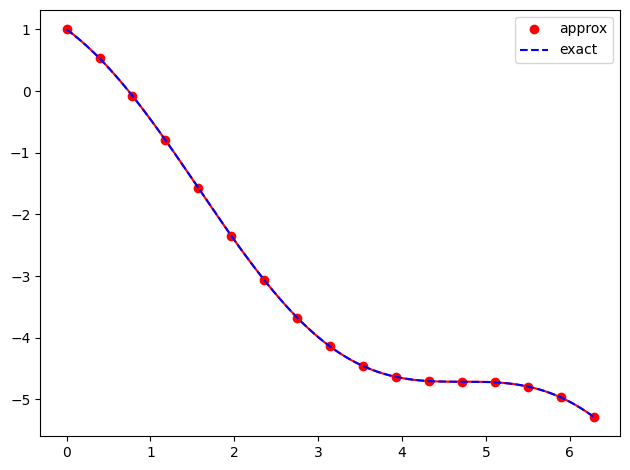

In [ ]:
geom = Geometry1D(0.,2*np.pi,N=5)

boundary = dict()
boundary["left"] = ["dirichlet", 1.]
#boundary["right"] = ["dirichlet", 1.-2*np.pi]
boundary["right"] = ["neumann", -1.]

uex_lambda = lambda x: np.cos(x)-x
f_lambda = lambda x: np.cos(x) + 2 * x * (np.cos(x)-x)

problem = Poisson_Finite_Element_1D_reaction(geom, boundary, f_lambda, sigma_lambda=lambda x: 2*x, degree=4)
problem.set_exact_solution(uex_lambda)

plt.figure()
geom,uu,error = problem.solve()

problem.fem1d.plot_function(uu,uex_lambda)
#plt.plot(problem.fem1d.DoFs,uu,label="approximation")
#plt.plot(problem.fem1d.DoFs,uex_lambda(problem.fem1d.DoFs),label="exact")
#plt.legend()
print(error)